In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import glob
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.09 GB


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')


In [7]:
# data_dir = "/content/drive/MyDrive/data/data/train"

# input_files = sorted(glob.glob(os.path.join(data_dir, 'input_*.csv')))
# output_files = sorted(glob.glob(os.path.join(data_dir, 'output_*.csv')))

# print(f"Input files: {len(input_files)}")
# print(f"Output files: {len(output_files)}")

In [8]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

print(f"Input files: {len(input_files)}")
print(f"Output files: {len(output_files)}")

Input files: 18
Output files: 18


In [9]:
input_dfs = []
output_dfs = []

for input_file, output_file in zip(input_files[:5], output_files[:5]):
    input_dfs.append(pd.read_csv(input_file))
    output_dfs.append(pd.read_csv(output_file))

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f"Input shape: {input_df.shape}")
print(f"Output shape: {output_df.shape}")

Input shape: (1399311, 23)
Output shape: (159814, 6)


In [10]:
merged_df = input_df.merge(
    output_df,
    on=['game_id', 'play_id', 'nfl_id'],
    suffixes=('_input', '_output')
)

print(f"Merged shape: {merged_df.shape}")

Merged shape: (4634163, 26)


In [11]:
feature_cols = ['x_input', 'y_input', 's', 'a', 'dir', 'o']
target_cols = ['x_output', 'y_output']

X = merged_df[feature_cols].fillna(0)
y = merged_df[target_cols].fillna(0)

print(f"Features: {X.shape}")
print(f"Targets: {y.shape}")

Features: (4634163, 6)
Targets: (4634163, 2)


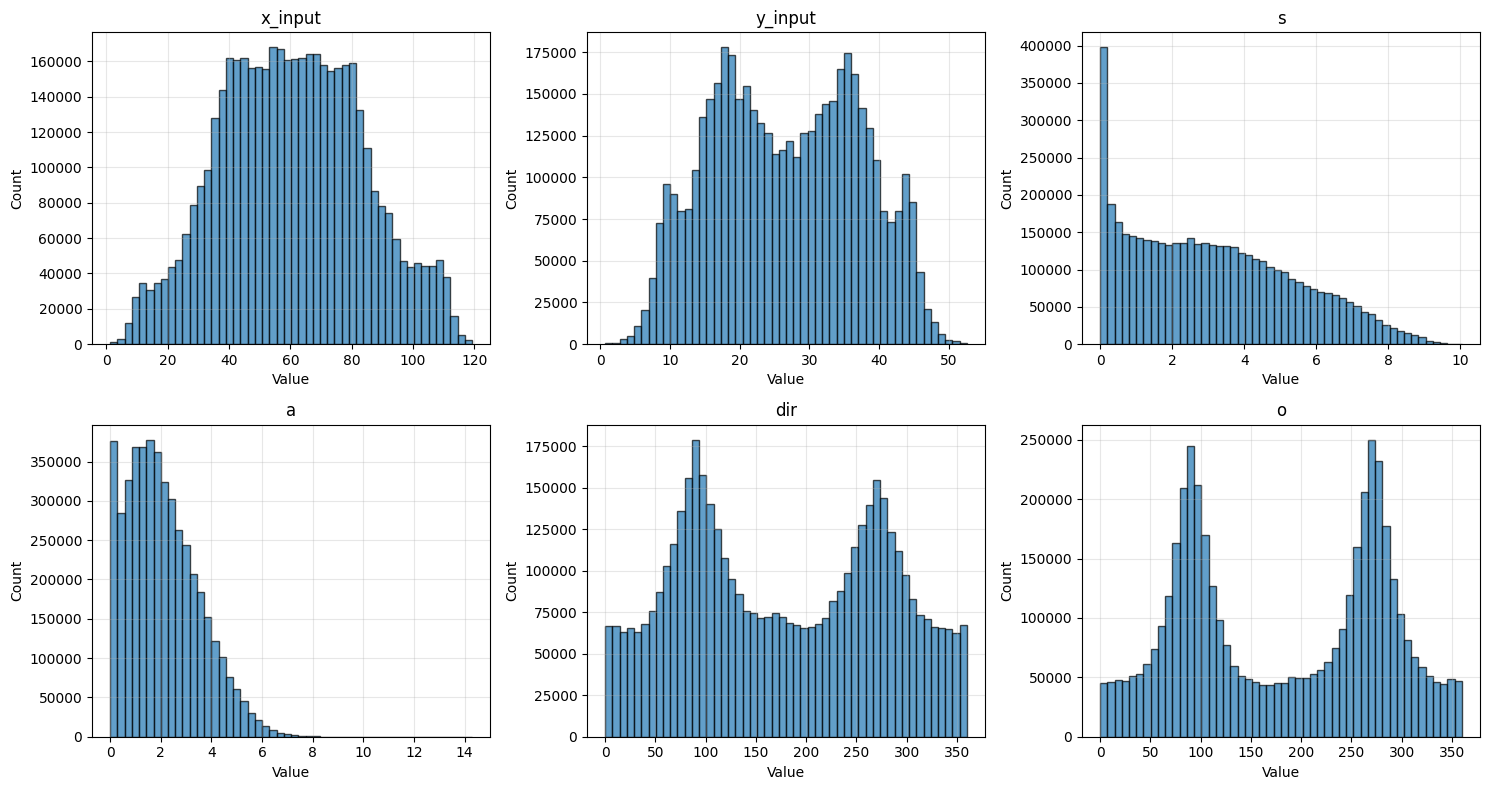

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

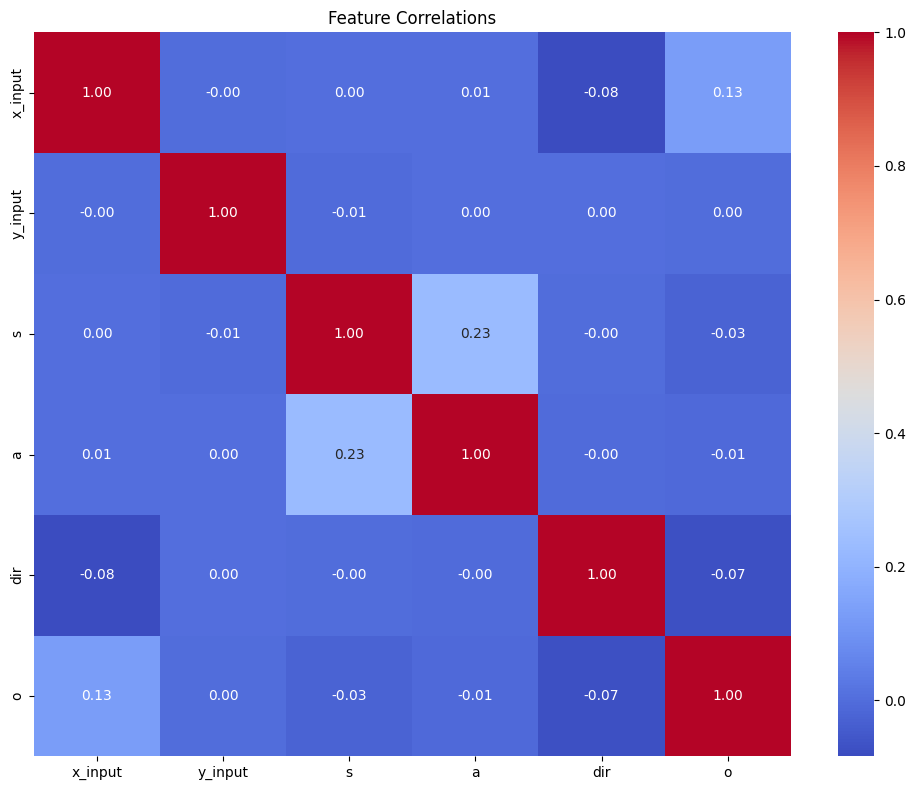

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (3707330, 6)
Test: (926833, 6)


In [15]:
# Preprocessing: scale features and convert to PyTorch tensors
from sklearn.preprocessing import StandardScaler
from joblib import dump
import torch
# Reproducibility
seed = 42
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)

# Fit scaler on training features and transform both train/test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for inference later
dump(scaler, 'scaler.joblib')

# Convert to float32 numpy arrays
X_train_arr = np.asarray(X_train_scaled, dtype=np.float32)
X_test_arr = np.asarray(X_test_scaled, dtype=np.float32)
y_train_arr = np.asarray(y_train.values, dtype=np.float32)
y_test_arr = np.asarray(y_test.values, dtype=np.float32)

# Reshape features to (N, C, L) for Conv1d. We'll use 1 channel and sequence length = number of features
seq_len = X_train_arr.shape[1]
X_train_t = torch.from_numpy(X_train_arr).unsqueeze(1)  # shape (N,1,seq_len)
X_test_t = torch.from_numpy(X_test_arr).unsqueeze(1)
y_train_t = torch.from_numpy(y_train_arr)
y_test_t = torch.from_numpy(y_test_arr)

print('Prepared tensors:', X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)

Prepared tensors: torch.Size([3707330, 1, 6]) torch.Size([3707330, 2]) torch.Size([926833, 1, 6]) torch.Size([926833, 2])


In [16]:
# Create TensorDatasets and DataLoaders
from torch.utils.data import TensorDataset, DataLoader
batch_size = 256
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print('Batches (train,valid):', len(train_loader), len(valid_loader))

Batches (train,valid): 14482 3621


CNN LSTM

In [17]:
class CNNLSTM(nn.Module):
    #1d cnn lstm
    #input shape is (batch_size, 1, seq_len)
    #output shape is (batch_size, 2)
    def __init__(self, seq_len, out_dim=2):
        super().__init__()
        # 1d convolution layer
        self.conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # lstm layer
        #hidden size 32 means lstm will keep a 32 dim memory
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        #final linear layer that maps from lstm hidden state to x,y coordinates
        self.fc = nn.Linear(32, out_dim)

    def forward(self, x):
        #x starts as shape (batch_size, 1, seq_len)
        #apply 1d cnn
        x = self.conv(x)
        x = self.relu(x)
        #now shape is (batch_size, 16, seq_len)
        #lstm expects shape (batch_size, seq_len, features)
        #so we swap the last two dimensions
        x = x.permute(0, 2, 1)#now shape (batch_size, seq_len, 16)
        #pass through lstm
        #get lstm hidden state
        _, (h_n, _) = self.lstm(x)
        #h_n shape (num_layers, batch_size, hidden_size)
        #take the last layer's hidden state
        h_last = h_n[-1]#shape (batch_size, 32)
        #pass hidden state through final linear layer
        out = self.fc(h_last)#shape (batch_size, 2)
        return out

seq_len = train_loader.dataset.tensors[0].shape[-1]  #should be 6
model = CNNLSTM(seq_len=seq_len, out_dim=2).to(device)


In [ ]:
#loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50
#training loop
for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        #xb is input batch, shape (batch_size, 1, seq_len)
        #yb is target batch, shape (batch_size, 2)
        xb = xb.to(device)
        yb = yb.to(device)

        #reset gradients to zero before each step
        optimizer.zero_grad()

        #get predictions from the model (forward pass)
        preds = model(xb)

        #compute loss between predictions and true targets
        loss = criterion(preds, yb)

        #compute graidents (backward pass)
        loss.backward()

        #update model weights
        optimizer.step()

        #keep track of this batch's loss
        train_losses.append(loss.item())

    #avg training loss over all batches
    avg_train_loss = float(np.mean(train_losses))

    #validation
    model.eval()
    val_losses = []
    with torch.no_grad():  #no gradient updates
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())

    avg_val_loss = float(np.mean(val_losses))
    print(
        f"epoch {epoch:02d} | "
        f"train loss: {avg_train_loss:.6f} | "
        f"val loss: {avg_val_loss:.6f}"
    )

print("training done")

epoch 01 | train loss: 221.288563 | val loss: 42.198759
epoch 02 | train loss: 41.395136 | val loss: 40.857997
epoch 03 | train loss: 40.527018 | val loss: 40.406572
epoch 04 | train loss: 39.987684 | val loss: 40.160675
epoch 05 | train loss: 39.567721 | val loss: 39.521307
epoch 06 | train loss: 39.231829 | val loss: 39.207220
epoch 07 | train loss: 38.956920 | val loss: 39.133091
epoch 08 | train loss: 38.715963 | val loss: 38.647856
epoch 09 | train loss: 38.510744 | val loss: 38.436260
epoch 10 | train loss: 38.317961 | val loss: 38.312927
epoch 11 | train loss: 38.165678 | val loss: 38.214475
epoch 12 | train loss: 38.025287 | val loss: 38.104106
epoch 13 | train loss: 37.898704 | val loss: 37.898213
epoch 14 | train loss: 37.775431 | val loss: 37.993524
epoch 15 | train loss: 37.664491 | val loss: 37.667768
epoch 16 | train loss: 37.568354 | val loss: 37.620463
epoch 17 | train loss: 37.475711 | val loss: 37.409594
epoch 18 | train loss: 37.385778 | val loss: 37.360428
epoch 19 